In [1]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

import struct

import pandas as pd

In [2]:
pcapfiles=sorted(glob.glob('*.pcap'))

In [3]:
print(pcapfiles, len(pcapfiles))

['zpectro_fc800Mhz_v1.pcap', 'zpectro_fc800Mhz_v2.pcap', 'zpectro_fc800Mhz_v3.pcap', 'zpectro_fc800Mhz_v4.pcap', 'zpectro_fc800Mhz_v5.pcap', 'zpectro_fc800Mhz_v6.pcap', 'zpectro_fc800Mhz_v7.pcap', 'zteste1.pcap', 'zteste2.pcap', 'zteste3.pcap', 'zteste4.pcap', 'zteste5.pcap', 'zteste6.pcap', 'zteste7.pcap', 'zteste_2can_fc120_bw128.pcap', 'zteste_2can_fc120_bw128_2.pcap', 'zteste_2canais_fc110.pcap', 'zteste_2canais_fc110_2.pcap', 'zteste_2canais_fc110_3.pcap'] 19


In [4]:
esse=pcapfiles[5]
print(esse)
with open(esse,'rb') as f:
    mybuff=f.read()

#o zspectro está com banda de 93.75 MHz e 32768 canais

zpectro_fc800Mhz_v6.pcap


In [5]:
#mostrar tamanho em bytes (8 bits)
len(mybuff)
#mostrar em formato binário (scary!) 
print(mybuff[:60])
#mostrar em formato hexdecimal (less scary!)
print(mybuff[:60].hex())

b'\xd4\xc3\xb2\xa1\x02\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x00\x00\x00\x16)\xb6g\xbfE\x07\x00\x8a \x00\x00\x8a \x00\x00\x1c\xfd\x08}X\x99\x06P\x02\x0f\x03\x01\x08\x00E\x00 |\x00\x00'
d4c3b2a102000400000000000000000000000400010000001629b667bf4507008a2000008a2000001cfd087d58990650020f030108004500207c0000


In [6]:
"""
Transformar em um np.array formado de int8 o array acima para manter a quantidade de números.
Isso vai ajudar a manipular o array com os métodos do numpy
Removemos os 24 primeiros elementos, pois é uma espécie de header geral. 
O procedimento será ir descobrindo o que é header geral (comparando com o output do wireshark),
e depois ver o que é header e dados em cada header
"""

dt = np.dtype('int8')
coisa_int8=np.frombuffer(mybuff,dt)
newcoisa_int8=coisa_int8[24:]
print(newcoisa_int8.shape)
newcoisa_int8[:100].data.hex()

(17092608,)


'1629b667bf4507008a2000008a2000001cfd087d58990650020f030108004500207c00004000ff11513b0a2a000c000000002710000020680000530402060000000b800100000000003c8002000000080000800300000000000080040000000020009011'

In [7]:
# fazer um reshape com 8346 e o que sobre é o número de frames.
# Controlamos o número de frames com o flag -c no tcpdump
nn_re=newcoisa_int8.reshape(-1,8346)
print(nn_re.shape)
print(nn_re)
# notar que as colunas iniciais são iguais, implicando algum tipo de header (iguais) de cada frame

(2048, 8346)
[[ 22  41 -74 ...   0   0   0]
 [ 22  41 -74 ...   0   0   0]
 [ 22  41 -74 ...   0   0   0]
 ...
 [ 84  41 -74 ...   0   0   0]
 [ 84  41 -74 ...   0   0   0]
 [ 84  41 -74 ...   0   0   0]]


In [8]:
# retira um header antes dos dados do UDP...o pacote UDP tem 8330 bytes (ou int8) de acordo com o wireshark 
# Daí tem uma parte para ser removida até 2888 e por fim dados mesmo são 8192. 
# Portanto será preciso remover ainda 8330-8192=138 elementos no início de cada frame
new_re=nn_re[:,16:] 
print(new_re.shape)
print(new_re[:10,:10])
print(new_re.flatten()[:148].data.hex())

(2048, 8330)
[[  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]
 [  28   -3    8  125   88 -103    6   80    2   15]]
1cfd087d58990650020f030108004500207c00004000ff11513b0a2a000c000000002710000020680000530402060000000b800100000000003c8002000000080000800300000000000080040000000020009011000000000000901500000000165a9009000000008000904600000a6e49c090270000000000b596000000056d5cec180000000000000000000001000000000000


In [9]:
#138  -> 10

frame_headers=new_re[:,:138]
final_re=new_re[:,138:]
print(final_re.shape)
print(final_re[-25:,:10])
print(final_re.flatten()[:10].data.hex())

(2048, 8192)
[[ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]]
00000001000000000000


In [10]:
8192*1000/32768

250.0

In [11]:
te1=final_re.reshape(-1)  # pode ser usado o método .flatten().
print(te1.shape)
print(te1[:10])

#te11=np.concatenate((te1,np.zeros(2*8192)))

#t21=te11.reshape(-1,8192)
#print(t21.shape)
# As linhas abaixo é para fazer um check de comparação se o reshape(-1) ou .flatten funciona direito
#te3=te1.reshape(-1,8192)  #just to test and check with final_re
#print(te3.shape)
#te3[:10,:10]

(16777216,)
[0 0 0 1 0 0 0 0 0 0]


In [12]:
# Voltar para bytes
te1_bytes=te1.tobytes()

# caso queira ver em hex.
#te1_hex=te1.data.hex()
#print(te1_hex[:50])

In [13]:
# os dados estão codificados em int16. Agora é para valer:

dt = np.dtype('uint32')
coisa=np.frombuffer(te1_bytes,dt)
print(coisa.shape)

(4194304,)


In [14]:
wf_1=coisa.reshape(-1,)
print(wf_1.shape)

(4194304,)


In [15]:
wf_2=wf_1.flatten()
wf_2[:40]
#print(wf_2.shape)

array([16777216,        0,        0,        0, 16777216,        0,
              0,        0, 16777216,        0,        0,        0,
       16777216,        0,        0,        0, 16777216,        0,
              0,        0, 16777216,        0,        0,        0,
       16777216,        0,        0,        0, 16777216,        0,
              0,        0, 16777216,        0,        0,        0,
       16777216,        0,        0,        0], dtype=uint32)

In [16]:
i0=wf_2[0::4]
i1=wf_2[1::4]

i0.shape

(1048576,)

In [17]:
2**14

16384

In [18]:
i0_n=i0.reshape(-1,32768)
i0_n.shape

(32, 32768)

In [19]:
#o zspectro está com banda de 93.75 MHz e 32768 canais
bw=93.75
fc=800
fi,ff=fc-bw/2, fc+bw/2
freqs=np.linspace(fi,ff,i0_n.shape[1])

ti, tf=0, i0_n.shape[0]
tt=np.linspace(ti,tf,tf)

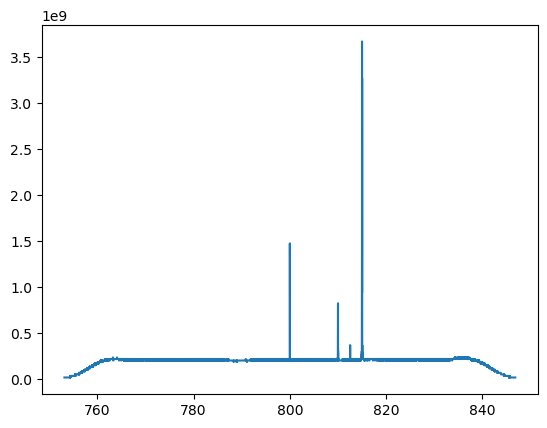

In [20]:
plt.plot(freqs,i0_n[20,:])

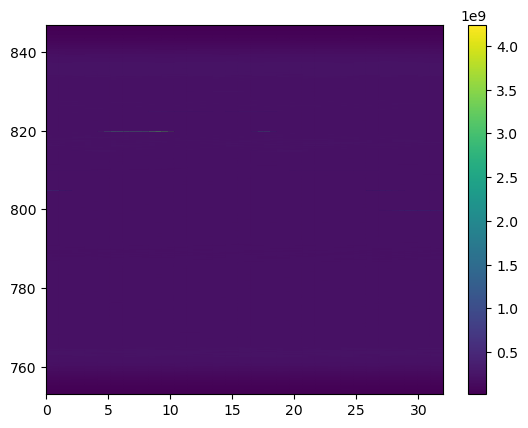

In [21]:
plt.pcolormesh(tt,freqs,i0_n.T,shading='gouraud')
plt.colorbar()

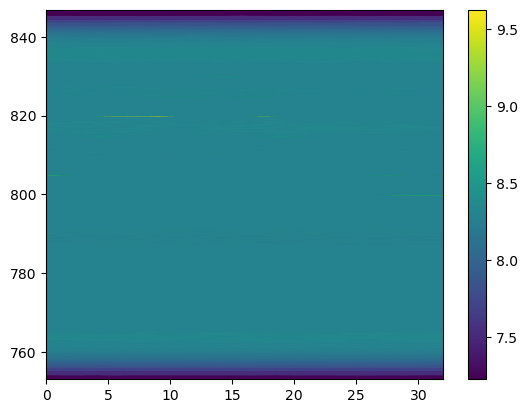

In [22]:
plt.pcolormesh(tt,freqs,np.log10(i0_n.T),shading='gouraud')
plt.colorbar()

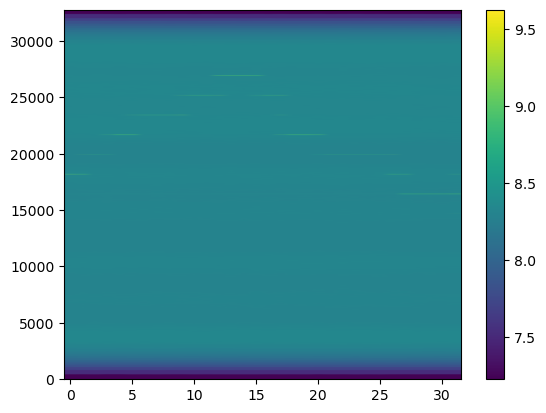

In [23]:
plt.imshow(np.log10(i0_n.T),aspect='auto',origin='lower')
plt.colorbar()

In [24]:
print(i0_n.shape)

(32, 32768)


In [25]:
# média ao longo de alguns canais para combinar em canais maiores

newmat=i0_n.T.reshape(-1,16,32)
print(newmat.shape)
finalmat=np.mean(newmat,axis=1)
print(finalmat.shape)

(2048, 16, 32)
(2048, 32)


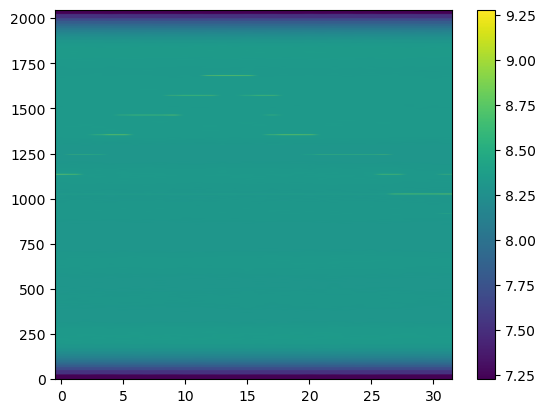

In [26]:
plt.imshow(np.log10(finalmat),aspect='auto',origin='lower')
plt.colorbar()

In [27]:
finalmat.shape

(2048, 32)

In [28]:
# Fazendo uma figura mais bacana

# o que plotar

frqs=np.linspace(fi,ff,finalmat.shape[0])
tts=np.linspace(ti,tf,finalmat.shape[1])

t_series=np.mean(finalmat,axis=0)
specs_mean=np.mean(finalmat,axis=1)

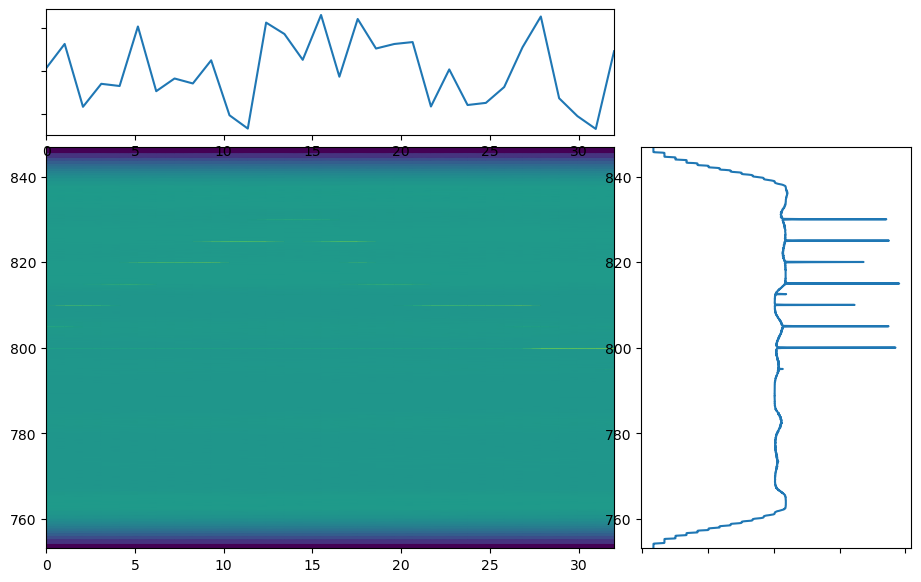

In [29]:

#Montando a grade
fig=plt.figure(figsize=(15,7))
mygrid=plt.GridSpec(4,4,hspace=0.1,wspace=0.1)

main_ax=fig.add_subplot(mygrid[1:,:2])
time_ax=fig.add_subplot(mygrid[0,:2],yticklabels=[],sharex=main_ax)
spec_ax=fig.add_subplot(mygrid[1:,2],xticklabels=[],sharey=main_ax)

#plotando
main_ax.pcolormesh(tts,frqs,np.log10(finalmat),shading='gouraud')

time_ax.plot(tts,t_series)
spec_ax.plot(specs_mean,frqs)

#plt.savefig('zspec_skarab.png')

In [30]:
print(frame_headers.shape)
frame_headers[:2,:66]

(2048, 138)


array([[  28,   -3,    8,  125,   88, -103,    6,   80,    2,   15,    3,
           1,    8,    0,   69,    0,   32,  124,    0,    0,   64,    0,
          -1,   17,   81,   59,   10,   42,    0,   12,    0,    0,    0,
           0,   39,   16,    0,    0,   32,  104,    0,    0,   83,    4,
           2,    6,    0,    0,    0,   11, -128,    1,    0,    0,    0,
           0,    0,   60, -128,    2,    0,    0,    0,    8,    0,    0],
       [  28,   -3,    8,  125,   88, -103,    6,   80,    2,   15,    3,
           1,    8,    0,   69,    0,   32,  124,    0,    0,   64,    0,
          -1,   17,   81,   59,   10,   42,    0,   12,    0,    0,    0,
           0,   39,   16,    0,    0,   32,  104,    0,    0,   83,    4,
           2,    6,    0,    0,    0,   11, -128,    1,    0,    0,    0,
           0,    0,   60, -128,    2,    0,    0,    0,    8,    0,    0]],
      dtype=int8)

In [31]:
frm_hdr=frame_headers[3,128:].tobytes()
frm_hdr.hex()

'5cec1800000000000000'

In [32]:
128/8

16.0